In [ ]:
#the statistics of the eclipse data

# FIXING TIME NOT TRIAGING TIME

In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

from global_functions import *

In [2]:
release_creation_ts_all = get_release_dates()

In [3]:
#Load data
df = pd.read_csv('./data/bugs_info.csv',index_col=False,dtype={'release':str,'version':str})
df = df.fillna('')
df['release'] = df.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
df['release'] = df['release'].astype(str)
df = trans_to_datetime(df,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])
df.head(n=2)

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False


In [4]:
yearly_file = 'data'+os.sep+'bugs_info.csv'
df_monthly = pd.read_csv(yearly_file,index_col=False,
                                        dtype={'release': str,'version':str})
df_monthly['release'] = df_monthly.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
df_monthly.head()

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaN,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,NaN,0.0,0.0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaN,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,NaN,0.0,0.0,4.6,4.6,False,False
2,475370,4.5,Platform,2015-08-19 12:09:06,4.5,DUPLICATE,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
3,475379,4.5,Platform,2015-08-19 13:39:12,4.5,NaN,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
4,475407,4.5,Platform,2015-08-19 17:06:10,4.5,FIXED,0,1,1,NaN,...,2015-08-19 17:15:25,2015-08-19 17:15:25,2015-08-19 17:15:25,NaN,0.0,0.0,4.5,4.5,False,False


In [5]:
df_monthly.release.unique()

array(['4.5', '4.6', '4.4', '3.7', '4.2', '4.3', '3.6', '4.8', '3.1',
       '4.7', '4.10', '3.4', '3.5', '3.3', '3.2', '3.0', '4.9'],
      dtype=object)

In [12]:
def get_monthly_fixing_stats_2(df_work,yearly_releases,fixedFirst,resolvedFirst):
    df_work = trans_to_datetime(df_work,['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date','last_fixed_date'])
    
    df_work['release'] = df_work['release'].astype(str)
    mon_stats = pd.DataFrame()
        
        
    if fixedFirst:
        fix_column = 'first_fixed_date'
    else:
        fix_column = 'last_fixed_date'
        
  

    for release in sorted(df_work.release.unique().tolist()):
        release = str(release)
        pred=predecessor(yearly_releases,release)
        #print(release,pred)
        release_date = release_creation_ts_all[release]
        release_date = pd.to_datetime(release_date)

        dfw = df_work[df_work['release']==pred]
        dfw = trans_to_datetime(dfw,['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])
        
        release_events = []
        release_events.append(dfw.creation_time.min())
        release_events.append(dfw[fix_column].min())
        end_inspection = min(release_events)
        
        month=-1
        while month <11:
            month+=1
            end_period = release_date-timedelta(30*month)
            if end_period < end_inspection:
                print('hi break')
                break
            start_period = release_date-timedelta(30*(month+1))
            
            #print('Month:'+str(month)+' - '+str(start_period)+'->'+str(end_period)+' before ')
            
            
            bugs_fixed = (
                dfw[(dfw[fix_column]>=start_period)
                                 & 
                    (dfw[fix_column]<end_period)]
            )
            bugs_fixed = bugs_fixed[['id','release','Product','creation_time',fix_column]].drop_duplicates()
            bugs_fixed['type'] = 'fixed'
            

            
            
            all_dfs = pd.DataFrame()
            #all_dfs = all_dfs.append(bugs_reported, ignore_index=True)
            #all_dfs = all_dfs.append(bugs_resolved, ignore_index=True)
            all_dfs = all_dfs.append(bugs_fixed, ignore_index=True)
           # all_dfs = all_dfs.append(bugs_fixed, ignore_index=True)
            all_dfs['start_period'] = start_period
            all_dfs['end_period'] = end_period
            all_dfs['month'] = month+1
            all_dfs['period'] = 'before'
            #print(pred,release)
            all_dfs['release'] = release
            all_dfs['predecessor'] = str(pred)
            #print(all_dfs['predecessor'].unique())

            mon_stats = mon_stats.append(all_dfs,ignore_index=True)
        
    return mon_stats

In [13]:
e_t_file = 'data'+os.sep+'RQ3'+os.sep+'releases_monthly_stats_last_fix_E.csv'
if not os.path.exists(e_t_file):
    df_monthly_stats_first_2 = get_monthly_fixing_stats_2(df_monthly,list(release_creation_ts_all.keys()),fixedFirst=False,resolvedFirst=False)
    df_monthly_stats_first_2.to_csv(e_t_file,index=False)
else:
    df_monthly_stats_first_2 = pd.read_csv(e_t_file,index_col=False,
                                          dtype={'release': str})
    
df_monthly_stats_first_2['release'] = df_monthly_stats_first_2['release'].astype(str)
df_monthly_stats_first_2['month'] = df_monthly_stats_first_2.apply(lambda x : reverse_month(x['month']), axis=1)
df_monthly_stats_first_2.head()

,id,release,Product,creation_time,last_fixed_date,type,start_period,end_period,month,period,predecessor
0,100923,3.1,Platform,2005-06-20 18:16:37,2005-06-22 12:54:30,fixed,2005-05-29,2005-06-28,12,before,3.0
1,101160,3.1,Platform,2005-06-21 22:03:45,2005-06-22 19:59:40,fixed,2005-05-29,2005-06-28,12,before,3.0
2,65216,3.1,Platform,2004-06-02 02:58:22,2005-06-09 18:21:31,fixed,2005-05-29,2005-06-28,12,before,3.0
3,65775,3.1,Platform,2004-06-04 18:22:30,2005-06-16 18:09:38,fixed,2005-05-29,2005-06-28,12,before,3.0
4,65786,3.1,Platform,2004-06-04 19:11:53,2005-06-02 16:29:39,fixed,2005-05-29,2005-06-28,12,before,3.0


In [14]:
df_monthly_stats_first_2.release.unique()

array(['3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '4.10', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9'], dtype=object)

In [15]:
e_target_file = 'data'+os.sep+'RQ3'+os.sep+'time_fix_E.csv.gz'
if not os.path.exists(e_target_file):
    df_total=df_monthly_stats_first_2.copy()
    df_total = trans_to_datetime(df_total,['last_fixed_date','creation_time'])
    df_total['fixing_time'] =df_total.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
    df_total= df_total[['id','month','fixing_time' ,'release' ]]        
        
    df_total.to_csv(e_target_file,index=False,compression='gzip')
else:
    df_total=pd.read_csv(e_target_file,index_col=False,compression='gzip',
                                          dtype={'release': str})
df_total.head()    

,id,month,fixing_time,release
0,100923,12,1,3.1
1,101160,12,0,3.1
2,65216,12,372,3.1
3,65775,12,376,3.1
4,65786,12,362,3.1


3.1


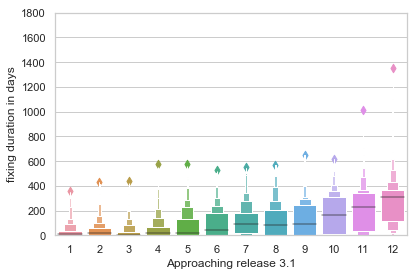

3.2


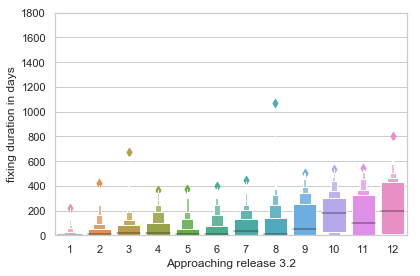

3.3


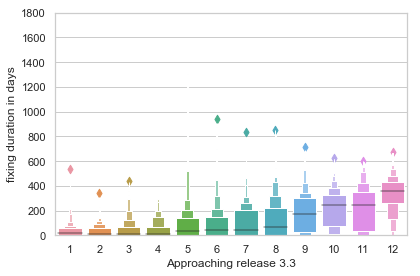

3.4


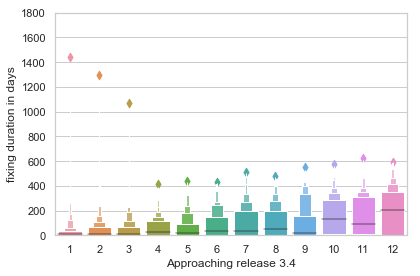

3.5


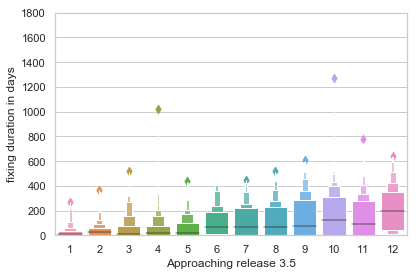

3.6


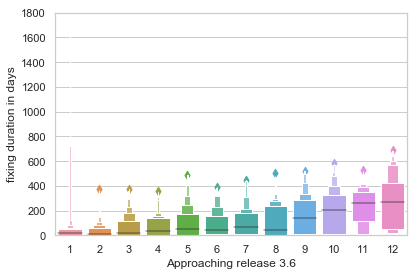

3.7


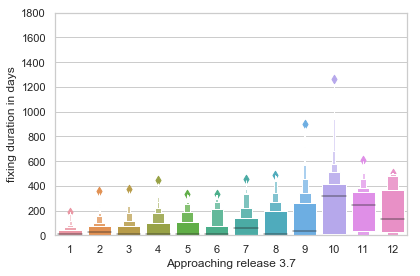

4.2


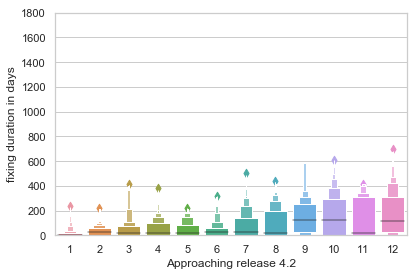

4.3


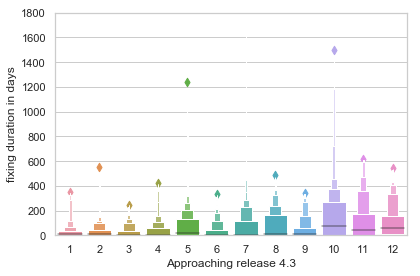

4.4


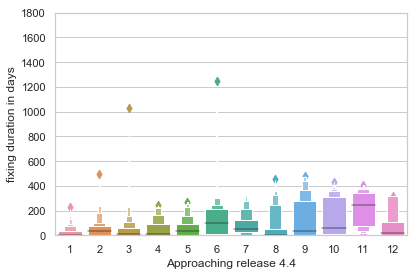

4.5


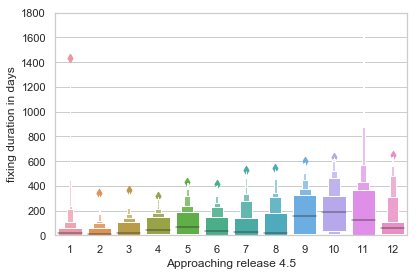

4.6


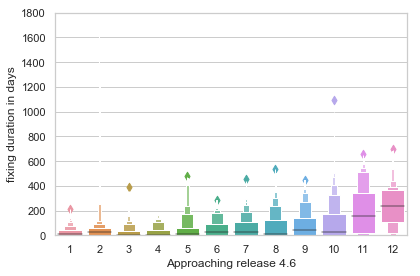

4.7


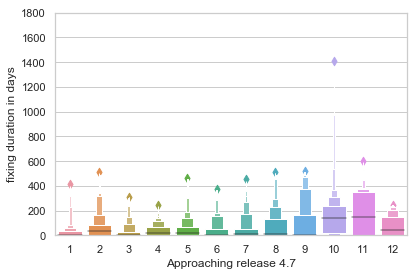

4.8


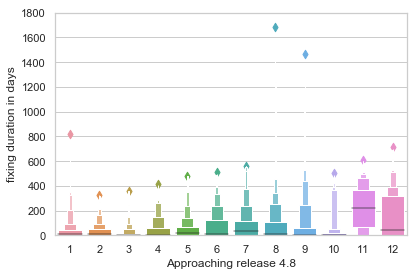

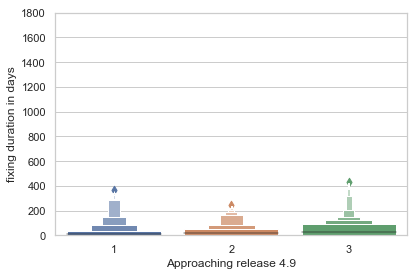

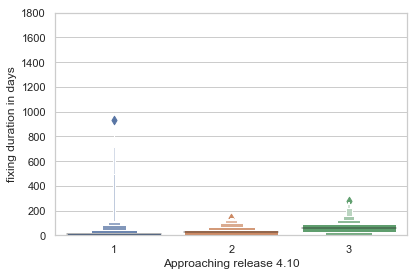

In [16]:
r_month=[10,11,12]

releases_only = df_total[['release']].drop_duplicates()
releases_only = sort_df(releases_only,'release')
releases_only = releases_only[['release']]

for release in releases_only.release.unique():
#release='4.3'
    release=str(release)
    if (release!='4.9') & (release!='4.10'):
        print(release)
        sns.set(style="whitegrid")
        draft=df_total[(df_total['release']==release) ]
        ax = plt.subplot(1, 1,1)
        
        sns.boxenplot(x=draft['month'], y=draft['fixing_time'])
        ax.set_xlabel("Approaching release "+release)
        ax.set_ylabel("fixing duration in days")
        ax.set_ylim(0, 1800)
        plt.tight_layout( )
        plt.show()
        ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'figs'+os.sep+'RQ3'+os.sep+'fixingRate'+release.replace('.', '-')+'.pdf', bbox_inches="tight")
        
    else:
        sns.set(style="whitegrid")
        draft=df_total[(df_total['release']==release) & (df_total['month'].isin(r_month))]
        ax = plt.subplot(1, 1,1)  
        sns.boxenplot(x=draft['month'], y=draft['fixing_time'])
        ax.set_xlabel("Approaching release "+release)
        ax.set_ylabel("fixing duration in days")
        ax.set_ylim(0, 1800)
        ax.set_xticklabels( ('1', '2','3') )
        plt.tight_layout( )
        plt.show()
        ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'figs'+os.sep+'RQ3'+os.sep+'fixingRate'+release.replace('.', '-')+'.pdf', bbox_inches="tight")            
    
#plt.savefig('rq3t4-4.pdf')